In [ ]:
!pip install konlpy #한글 형태소 분석 라이브러리
!pip install pymysql
!pip install gensim --upgrade
!pip install emoji
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 11.4 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=b5eb8a57d2209e741311e946dcc83803c32d2a6d54da3bfb9b63b49b2af7afd2
  Stored in dir

In [ ]:
import konlpy
from gensim.models import FastText
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pymysql
import emoji
from sklearn.model_selection import train_test_split
from soynlp.hangle import compose, decompose, character_is_korean
import logging
from tqdm import trange
import os
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

In [ ]:
def extract_emojis(text):
    for c in text:
        if c in emoji.UNICODE_EMOJI['en']:
          text = re.sub(c, "", text)
    
    return text

def jamo_sentence(sent):
    def transform(char):
        if char == ' ':
            return char
        cjj = decompose(char)
        if len(cjj) == 1:
            return cjj
        cjj_ = ''.join(c if c != ' ' else '-' for c in cjj)
        return cjj_

    sent_ = []
    for char in sent:
        if character_is_korean(char):
            sent_.append(transform(char))
        else:
            sent_.append(char)
    sent_ = doublespace_pattern.sub(' ', ''.join(sent_))
    return sent_





def jamo_to_word(jamo):
    jamo_list, idx = [], 0
    while idx < len(jamo):
        if not character_is_korean(jamo[idx]):
            jamo_list.append(jamo[idx])
            idx += 1
        else:
            jamo_list.append(jamo[idx:idx + 3])
            idx += 3
    word = ""

    try:
      for jamo_char in jamo_list:
          if len(jamo_char) == 1:

              word += jamo_char

          elif jamo_char[2] == "-":
              
              try:
                word += compose(jamo_char[0], jamo_char[1], " ")
              except:
                word += jamo_char
                continue
          else:
              try:
                word += compose(jamo_char[0], jamo_char[1], jamo_char[2])
              except:
                word += jamo_char
                continue
    except:
      pass
      
    return word

def process_jamo(tokenized_corpus_fname, output_fname):
    toatal_lines = sum(1 for line in open(tokenized_corpus_fname, 'r', encoding='utf-8'))

    with open(tokenized_corpus_fname, 'r', encoding='utf-8') as f1, \
            open(output_fname, 'w', encoding='utf-8') as f2:

        for _, line in tqdm(enumerate(f1), total=toatal_lines):
            sentence = line.replace('\n', '').strip()
            processed_sentence = jamo_sentence(sentence)
            f2.writelines(processed_sentence + '\n')

def transform(list):
    return [(jamo_to_word(w), r) for (w, r) in list]


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len, (cnt / len(nested_list))*100))

def mean_word_predict_morpheme(new_sentence):
  new_sentence = [new_sentence]
  pd.DataFrame(new_sentence).to_csv('sentence.txt',index = False, header = False)
  sentence_txt = '/content/sentence.txt'
  new_sentence_txt = '/content/newsentence.txt'
  process_jamo(sentence_txt, new_sentence_txt)
  new_sentence_final = [sent.strip().split(" ") for sent in tqdm(open(new_sentence_txt, 'r', encoding='utf-8').readlines())]
  new_sentence3 = []
  for a in new_sentence_final:
    new_sentence2 = []
    for word in a:
      ft_modeled = model_morphs.wv.get_vector(word)
      new_sentence2.append(ft_modeled)
    new_sentence3.append(new_sentence2)
  new_sentence3 = pad_sequences(new_sentence3, maxlen = max_len, padding='post', truncating = 'post', dtype = float )
  score = float(loaded_model_morpheme.predict(new_sentence3))
  if(score > 0.5):
    print("{:.2f}% 확률로 욕설입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 욕설이 아닙니다.\n".format((1 - score) * 100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
100%|██████████| 56787/56787 [00:03<00:00, 15245.31it/s]


corpus 생성


100%|██████████| 56787/56787 [00:00<00:00, 255841.39it/s]
2022-06-19 16:12:22,790 : INFO : collecting all words and their counts
2022-06-19 16:12:22,796 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-19 16:12:22,818 : INFO : PROGRESS: at sentence #10000, processed 46163 words, keeping 25798 word types
2022-06-19 16:12:22,839 : INFO : PROGRESS: at sentence #20000, processed 96973 words, keeping 48628 word types
2022-06-19 16:12:22,857 : INFO : PROGRESS: at sentence #30000, processed 137949 words, keeping 67908 word types
2022-06-19 16:12:22,876 : INFO : PROGRESS: at sentence #40000, processed 177777 words, keeping 83875 word types
2022-06-19 16:12:22,899 : INFO : PROGRESS: at sentence #50000, processed 222563 words, keeping 100495 word types
2022-06-19 16:12:22,916 : INFO : collected 110857 word types from a corpus of 251806 raw words and 56787 sentences
2022-06-19 16:12:22,923 : INFO : Creating a fresh vocabulary


학습 중


2022-06-19 16:12:23,834 : INFO : FastText lifecycle event {'msg': 'effective_min_count=1 retains 110857 unique words (100.00% of original 110857, drops 0)', 'datetime': '2022-06-19T16:12:23.834652', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-06-19 16:12:23,842 : INFO : FastText lifecycle event {'msg': 'effective_min_count=1 leaves 251806 word corpus (100.00% of original 251806, drops 0)', 'datetime': '2022-06-19T16:12:23.842021', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2022-06-19 16:12:25,209 : INFO : deleting the raw counts dictionary of 110857 items
2022-06-19 16:12:25,228 : INFO : sample=0.001 downsamples 15 most-common words
2022-06-19 16:12:25,230 : INFO : FastText lifecycle event {'msg': 'downsampling leaves estima

학습 소요 시간 : 18.52144282200001
완료


100%|██████████| 17037/17037 [00:00<00:00, 811372.16it/s]
2022-06-19 16:13:28,515 : INFO : loading FastText object from /content/final.model
2022-06-19 16:13:28,569 : INFO : loading wv recursively from /content/final.model.wv.* with mmap=None
2022-06-19 16:13:28,570 : INFO : loading vectors_vocab from /content/final.model.wv.vectors_vocab.npy with mmap=None
2022-06-19 16:13:28,591 : INFO : loading vectors_ngrams from /content/final.model.wv.vectors_ngrams.npy with mmap=None
2022-06-19 16:13:28,844 : INFO : setting ignored attribute vectors to None
2022-06-19 16:13:28,846 : INFO : setting ignored attribute buckets_word to None
2022-06-19 16:13:38,801 : INFO : loading syn1neg from /content/final.model.syn1neg.npy with mmap=None
2022-06-19 16:13:38,820 : INFO : setting ignored attribute cum_table to None
2022-06-19 16:13:39,840 : INFO : FastText lifecycle event {'fname': '/content/final.model', 'datetime': '2022-06-19T16:13:39.840753', 'gensim': '4.2.0', 'python': '3.7.13 (default, Apr 24

제목 최대 길이 : 52
제목 평균 길이 : 4.433761006289308


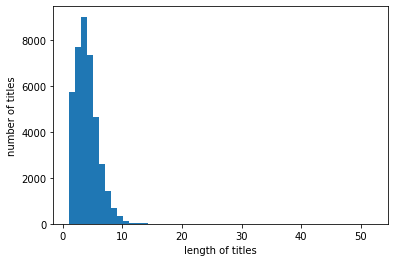

전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.93962264150943


In [ ]:
conn = pymysql.connect(
    user='study',
    passwd='hellobee1234',
    host='121.134.135.223',
    port=3306,
    db='data'
)
sql = "SELECT * FROM data.dataset;"
cursor = conn.cursor(pymysql.cursors.DictCursor)
cursor.execute(sql)
result = cursor.fetchall()
data = pd.DataFrame(result)
data.dropna(inplace=True)
data.sort_values(by='records').head(50)
data['records'] = data['records'].map(extract_emojis)
data['records'] = data['records'].str.replace(r'\[\d+\]', "")
data['records'] = data['records'].str.replace("\xa0", "")
data.dropna(inplace=True)
data.drop_duplicates(subset=['records'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data['records'], data['label'], test_size = 0.3, random_state = 123)

data["records"].to_csv('text.txt',index=False,header=False) 

doublespace_pattern = re.compile('\s+')

tokenized_corpus_fname = '/content/text.txt'
output_fname = '/content/edittext.txt'
process_jamo(tokenized_corpus_fname, output_fname)


corpus_fname = '/content/edittext.txt'
model_fname = '/content/final.model'

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

print('corpus 생성')
corpus = [sent.strip().split(" ") for sent in tqdm(open(corpus_fname, 'r', encoding='utf-8').readlines())]

print("학습 중")
model = FastText(corpus, vector_size=100, min_count=1, window=3, sg=1, negative=20)
model.save(model_fname)

X_train.to_csv('traintxt.txt', index = False, header = False)

X_test.to_csv('testtxt.txt', index = False, header = False)

train_record = '/content/traintxt.txt'
test_record = '/content/testtxt.txt'
train_output = '/content/edittraintxt.txt'
test_output = '/content/edittesttxt.txt'

process_jamo(train_record,train_output)

process_jamo(test_record,test_output)

train_record = [sent.strip().split(" ") for sent in tqdm(open(train_output, 'r', encoding='utf-8').readlines())]

test_record = [sent.strip().split(" ") for sent in tqdm(open(test_output, 'r', encoding='utf-8').readlines())]

model_morphs = FastText.load("/content/final.model")

morpheme_X_train = []
for a in train_record:
  morpheme_mid_train = []
  for word in a:
    ft_modeled = model_morphs.wv.word_vec(word)
    morpheme_mid_train.append(ft_modeled)
  morpheme_X_train.append(morpheme_mid_train)
np.array(morpheme_X_train).shape

morpheme_X_test = []
for b in test_record:
  morpheme_mid_test = []
  for word in b:
    ft_modeled = model_morphs.wv.word_vec(word)
    morpheme_mid_test.append(ft_modeled)
  morpheme_X_test.append(morpheme_mid_test)

print('제목 최대 길이 :',max(len(l) for l in morpheme_X_train))
print('제목 평균 길이 :',sum(map(len, morpheme_X_train))/len(morpheme_X_train))
plt.hist([len(s) for s in morpheme_X_train], bins=50)
plt.xlabel('length of titles')
plt.ylabel('number of titles')
plt.show()

max_len = 15
below_threshold_len(max_len, morpheme_X_train)

morpheme_X_train = pad_sequences(morpheme_X_train, maxlen = max_len, padding='post', truncating = 'post', dtype = float) 
morpheme_X_test = pad_sequences(morpheme_X_test, maxlen = max_len, padding='post', truncating = 'post', dtype = float)


In [ ]:
model = Sequential()
model.add(LSTM(units=512, input_shape=(15, 100)))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(units=256, activation='ELU'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(patience=4,restore_best_weights=True)
mc_m = ModelCheckpoint('./model/best_model_mean_words_morpheme.h5', save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(morpheme_X_train, y_train, epochs=100, callbacks=[es, mc_m], batch_size=128, validation_split=0.2)

print("\n Accuracy: %.4f" % (model.evaluate(morpheme_X_test, y_test)[1]))

loaded_model_morpheme = load_model('./model/best_model_mean_words_morpheme.h5')

Epoch 1/100
249/249 [==============================] - 10s 12ms/step - loss: 0.5597 - accuracy: 0.7246 - val_loss: 0.4777 - val_accuracy: 0.7849
Epoch 2/100
249/249 [==============================] - 2s 9ms/step - loss: 0.4783 - accuracy: 0.7787 - val_loss: 0.4682 - val_accuracy: 0.7836
Epoch 3/100
249/249 [==============================] - 2s 10ms/step - loss: 0.4689 - accuracy: 0.7880 - val_loss: 0.4487 - val_accuracy: 0.8019
Epoch 4/100
249/249 [==============================] - 2s 9ms/step - loss: 0.4482 - accuracy: 0.7995 - val_loss: 0.4500 - val_accuracy: 0.7927
Epoch 5/100
249/249 [==============================] - 2s 9ms/step - loss: 0.4352 - accuracy: 0.8049 - val_loss: 0.4292 - val_accuracy: 0.8175
Epoch 6/100
249/249 [==============================] - 2s 9ms/step - loss: 0.4304 - accuracy: 0.8092 - val_loss: 0.4286 - val_accuracy: 0.8162
Epoch 7/100
249/249 [==============================] - 2s 9ms/step - loss: 0.4231 - accuracy: 0.8134 - val_loss: 0.4178 - val_accuracy: 0.8

In [ ]:
mean_word_predict_morpheme("ㅅㅐ끼")

100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]

99.65% 확률로 욕설입니다.

